In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Input,MaxPool2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential




## Tensorflow Datasets

In this section we will familiarize ourselves with the Dataset object in Tensorflow

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train))

In [4]:
train_dataset=train_dataset.batch(16,drop_remainder=True)
print(train_dataset.cardinality())

print(train_dataset.element_spec)
e=train_dataset.take(1)
for img,label in e:
  print(label.numpy())

tf.Tensor(3750, shape=(), dtype=int64)
(TensorSpec(shape=(16, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(16,), dtype=tf.uint8, name=None))
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]


## Upload Kaggle Token

You will be prompted to upload your kaggle.json file to be able to access the kaggle API.

In [ ]:
from google.colab import files
file=files.upload()
!mkdir /root/.kaggle
!mv kaggle.json  /root/.kaggle
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip>/dev/null



### Retrieving the data as a Dataset Object

We use the image_dataset_from_directory to build a dataset from all the downloaded images. It is important to set the shuffle option to False for the test_dataset

In [7]:
image_size=(48,48)
dataset=tf.keras.preprocessing.image_dataset_from_directory("train",batch_size=64,image_size=image_size,
                                                            shuffle=True,color_mode="grayscale")
test_dataset=tf.keras.preprocessing.image_dataset_from_directory("test",batch_size=64,image_size=image_size,
                                                            shuffle=False,color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


print the class names

In [8]:
dataset.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

We can iterate over the dataset. Note each "element"  is a batch of batch_size

In [23]:
iterator=iter(dataset)
(imgs,labels)=iterator.next()
print(imgs.shape,labels.shape)


(64, 48, 48, 1) (64,)


Display an image from the dataset

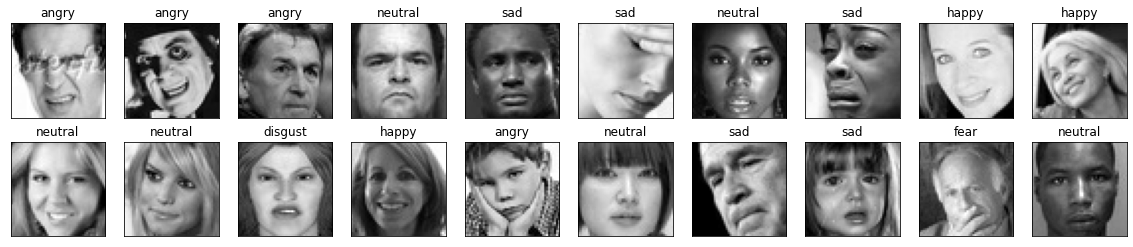

In [44]:
fig=plt.figure(figsize=(20,4))
#fig.tight_layout()
#plt.subplots_adjust( wspace=4)
for i in range(20):

            t=fig.add_subplot(2,10,i+1)
            # set the title of the image equal to its label
            t.set_title(str(dataset.class_names[labels[i].numpy()]))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(np.squeeze(imgs[i]),cmap='gray')

## Building the model

In [6]:
def get_model(nb_classes=7):
    model = Sequential()
    model.add(Input(shape=(image_size[0],image_size[1],1)))
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.5))
        
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.5))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation = 'softmax', name = 'Output'))
    model.summary()
    return model

### Add optimizer, loss and metrics

In [ ]:
model=get_model(nb_classes=7)
model.compile(optimizer="Adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

In [ ]:
try:
  model.load_weights("emotions_weights.h5")
except:
  pass

## Run optimizer

In [ ]:
model.fit(dataset,validation_data=test_dataset,epochs=20)

Epoch 1/20
449/449 [==============================] - 20s 45ms/step - loss: 1.5065 - accuracy: 0.4148 - val_loss: 1.3644 - val_accuracy: 0.4694
Epoch 2/20
449/449 [==============================] - 20s 45ms/step - loss: 1.3550 - accuracy: 0.4769 - val_loss: 1.2607 - val_accuracy: 0.5116
Epoch 3/20
449/449 [==============================] - 20s 45ms/step - loss: 1.2665 - accuracy: 0.5125 - val_loss: 1.1975 - val_accuracy: 0.5394
Epoch 4/20
449/449 [==============================] - 20s 45ms/step - loss: 1.2132 - accuracy: 0.5393 - val_loss: 1.1766 - val_accuracy: 0.5532
Epoch 5/20
449/449 [==============================] - 20s 45ms/step - loss: 1.1649 - accuracy: 0.5559 - val_loss: 1.1485 - val_accuracy: 0.5637
Epoch 6/20
449/449 [==============================] - 20s 45ms/step - loss: 1.1207 - accuracy: 0.5745 - val_loss: 1.1323 - val_accuracy: 0.5758
Epoch 7/20
449/449 [==============================] - 20s 45ms/step - loss: 1.0774 - accuracy: 0.5925 - val_loss: 1.1303 - val_accuracy:

Save the weights for later retrival and evaluate the model on the test data

In [ ]:
model.save_weights("emotions_weights.h5")
model.evaluate(test_dataset)

113/113 [==============================] - 7s 58ms/step - loss: 1.1082 - accuracy: 0.6053


[1.108216643333435, 0.6053218245506287]

# Prediction Accuracy and Confusion Matrix

In [ ]:
probabilities=model.predict(test_dataset)
predictions=np.argmax(probabilities,axis=1)
print(predictions[0:10])
predictions.shape

### Combine the "true" labels into an array

In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y.shape

(7178,)

### Count the number of correct and wrong predictions

In [ ]:

compare=y==predictions
unique,count=np.unique(compare,return_counts=True)
print(unique)
print(count)

[False  True]
[2833 4345]


### Confusion Matrix
The percentage of correct/wrong predictions doesn't tell the whole story. Some emotions are more correctly predicted than others. Towards that end we compute the confusion matrix

In [ ]:
m=tf.math.confusion_matrix(y,predictions)
m

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 530,    4,   66,   67,  103,  171,   17],
       [  29,   56,    5,    3,    4,   13,    1],
       [ 167,    5,  354,   50,  154,  216,   78],
       [  80,    0,   33, 1442,   94,   93,   32],
       [ 147,    3,   46,   99,  692,  240,    6],
       [ 172,    2,   95,   91,  205,  671,   11],
       [  44,    0,   64,   47,   40,   36,  600]], dtype=int32)>

In [ ]:
totals=np.sum(m.numpy(),axis=1)

for i in range(7):
  print("{}={:.3f}".format(dataset.class_names[i],m[i,i].numpy()/totals[i]))

angry=0.553
disgust=0.505
fear=0.346
happy=0.813
neutral=0.561
sad=0.538
surprise=0.722


### Plotting the Confusion Matrix

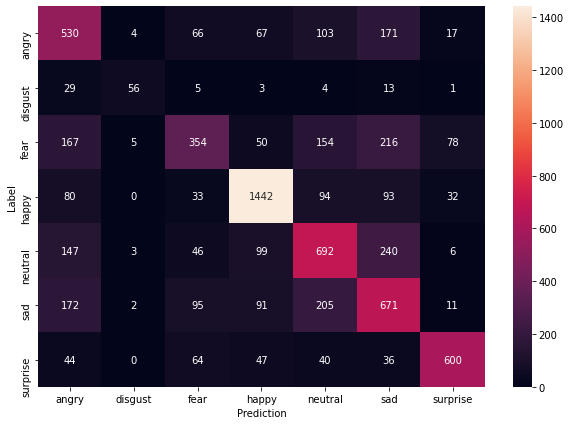

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(m, xticklabels=dataset.class_names, yticklabels=dataset.class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

6
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


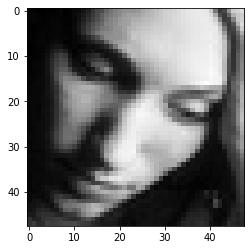

In [ ]:
idx=149
print(y[idx])
print(dataset.class_names)
plt.imshow(np.squeeze(x[idx]),cmap="gray")


## Classifying your own photo

In this part you will take a photo of yourself and classify it using a similar model. We will keep only 3 states : angry, happy and neutral. The easiest way is to delete the images for all the other categories and reload the dataset

In [8]:
image_size=(48,48)
train_dir="c:/Users/hikmat/Downloads/fer2013/train"
dataset=tf.keras.preprocessing.image_dataset_from_directory(train_dir,batch_size=64,image_size=image_size, shuffle=True,color_mode="grayscale")
model=get_model(nb_classes=3)
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.fit(dataset,epochs=10)


Found 16175 files belonging to 3 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_11 (C

In [13]:
import ipywidgets
from IPython import display
import cv2

In [46]:
# I have no idea who is the author of the code
# in this cell that saves an image from a webcam
# inside google colab.
# It comes from a notebook called "📸 Take a photo with your webcam"

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return len(binary)

In [56]:
img=take_photo(size=(96,96))

In [54]:
type(img)

numpy.ndarray

In [55]:
img.shape

(200, 300, 3)